https://eli5.readthedocs.io/en/latest/_modules/eli5/sklearn/explain_weights.html
https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#explaining-predictions

Also take a look at https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Allow more rows to be printed to investigate feature importance
pd.set_option('display.max_rows', 300)

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

# Mapping dict
mapping_dict_crop_types = {
    'Kartofler, stivelses-': 'Potato',
    'Kartofler, lægge- (egen opformering)': 'Potato',
    'Kartofler, andre': 'Potato',
    'Kartofler, spise-': 'Potato',
    'Kartofler, lægge- (certificerede)': 'Potato',
    'Vårbyg': 'Spring barley',
    'Vinterbyg': 'Winter barley',
    'Vårhvede': 'Spring wheat',
    'Vinterhvede': 'Winter wheat',
    'Vinterrug': 'Winter rye',
    'Vårhavre': 'Spring oat',
    'Silomajs': 'Maize',
    'Vinterraps': 'Rapeseed',
    'Permanent græs, normalt udbytte': 'Permanent grass',
    'Pil': 'Willow',
    'Skovdrift, alm.': 'Forest'
}


# Set seed for random generators
RANDOM_SEED = 42

# Seed the random generators
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [2]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc') 
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 52769, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 67365067 67365062
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 184 ms


In [3]:
ds.close()

time: 18.6 ms


In [4]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 9.06 s


In [6]:
df_sklearn = get_sklearn_df(polygons_year=2019, 
                            satellite_dates=slice('2018-01-01', '2019-12-31'), 
                            fields='all', 
                            satellite='S1B', 
                            polarization='all',
                            crop_type='all',
                            netcdf_path=netcdf_path)
    
df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped.insert(3, 'Crop type', '')
df_sklearn_remapped.insert(4, 'Label ID', 0)
mapping_dict = {}
class_names = [] 
i = 0
for key, value in mapping_dict_crop_types.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['afgroede'] == key, 'Crop type'] = value 
    if value not in class_names:
        class_names.append(value)
        mapping_dict[value] = i
        i += 1

for key, value in mapping_dict.items():
    df_sklearn_remapped.loc[df_sklearn_remapped['Crop type'] == key, 'Label ID'] = value 
#print(f"Crop types: {class_names}")

# Get values as numpy array
array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,5:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,4])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Instantiate and evaluate classifier
from sklearn.linear_model import LogisticRegression          
clf = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=32, max_iter=1000)
clf_trained, _, accuracy_test, results_report = evaluate_classifier(
    clf, X_train, X_test, y_train, y_test, class_names, feature_scale=True, plot_conf_matrix=False,
    print_classification_report=True)

Training time: 19.932 s
Prediction time: 0.0214 s

Report:

Train accuracy: 0.9164
Test accuracy: 0.9147

                  precision    recall  f1-score   support

         Potato       0.98      0.97      0.97      2320
  Spring barley       0.86      0.87      0.87      1151
  Winter barley       0.97      0.96      0.96      1336
   Spring wheat       0.64      0.39      0.49       454
   Winter wheat       0.92      0.95      0.93      1105
     Winter rye       0.94      0.95      0.94      1270
     Spring oat       0.83      0.85      0.84      1340
          Maize       0.94      0.95      0.95      1456
       Rapeseed       0.99      0.99      0.99      1091
Permanent grass       0.84      0.92      0.88      1145
         Willow       0.83      0.80      0.82       234
         Forest       0.90      0.86      0.88       405

       accuracy                           0.91     13307
      macro avg       0.89      0.87      0.88     13307
   weighted avg       0.91      0.91

In [24]:
# Get classfication report as pandas df
df_results = pd.DataFrame(results_report).transpose()  

# Round the values to 2 decimals
df_results = df_results.round(2).astype({'support': 'int32'})  

# Correct error when creating df (acc. is copied into 'precision')
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''  

# Correct error when creating df (acc. is copied into 'recall')
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  

# Correct error when creating df (acc. is copied into 'recall')
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''  

# The number of samples ('support') was incorrectly parsed in to dataframe
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[
    df_results.index == 'macro avg', 'support'].values

# Print df in latex format (I normally add a /midrule above accuracy manually)
print(df_results.to_latex(index=True))  

\begin{tabular}{lllrr}
\toprule
{} & precision & recall &  f1-score &  support \\
\midrule
Potato          &      0.98 &   0.97 &      0.97 &     2320 \\
Spring barley   &      0.86 &   0.87 &      0.87 &     1151 \\
Winter barley   &      0.97 &   0.96 &      0.96 &     1336 \\
Spring wheat    &      0.64 &   0.39 &      0.49 &      454 \\
Winter wheat    &      0.92 &   0.95 &      0.93 &     1105 \\
Winter rye      &      0.94 &   0.95 &      0.94 &     1270 \\
Spring oat      &      0.83 &   0.85 &      0.84 &     1340 \\
Maize           &      0.94 &   0.95 &      0.95 &     1456 \\
Rapeseed        &      0.99 &   0.99 &      0.99 &     1091 \\
Permanent grass &      0.84 &   0.92 &      0.88 &     1145 \\
Willow          &      0.83 &    0.8 &      0.82 &      234 \\
Forest          &       0.9 &   0.86 &      0.88 &      405 \\
accuracy        &           &        &      0.91 &    13307 \\
macro avg       &      0.89 &   0.87 &      0.88 &    13307 \\
weighted avg    &      0.91

In [23]:
df_results.loc[df_results.index == 'accuracy', 'precision'] = ''
df_results.loc[df_results.index == 'accuracy', 'recall'] = ''
df_results.loc[df_results.index == 'accuracy', 'support'] = df_results.loc[
    df_results.index == 'macro avg', 'support'].values
df_results

,precision,recall,f1-score,support
Potato,0.98,0.97,0.97,2320.0
Spring barley,0.86,0.87,0.87,1151.0
Winter barley,0.97,0.96,0.96,1336.0
Spring wheat,0.64,0.39,0.49,454.0
Winter wheat,0.92,0.95,0.93,1105.0
Winter rye,0.94,0.95,0.94,1270.0
Spring oat,0.83,0.85,0.84,1340.0
Maize,0.94,0.95,0.95,1456.0
Rapeseed,0.99,0.99,0.99,1091.0
Permanent grass,0.84,0.92,0.88,1145.0


time: 45.3 ms


In [8]:
try:
    from eli5 import show_weights
except:
    !conda install -y eli5

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - eli5


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eli5-0.10.1                |           py37_1         135 KB  conda-forge
    fribidi-1.0.9              |       h516909a_0         113 KB  conda-forge
    graphite2-1.3.13           |    he1b5a44_1001         102 KB  conda-forge
    graphviz-2.42.3            |       h0511662_0         6.9 MB  conda-forge
    harfbuzz-2.4.0             |       h9f30f68_3         1.5 MB  conda-forge
    libtool-2.4.6              |    h14c3975_1002         512 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pango-1.42.4   

In [9]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = df_sklearn.columns[3:]
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.explain_weights(clf, feature_names=list(feature_names), target_names=class_names)
# Look at https://eli5.readthedocs.io/en/latest/autodocs/formatters.html#eli5.formatters.html.format_as_html

# IMPORTANT: LOOK HERE TO FIND IMPORTANCE FOR INDIVIDUAL CLASSES:
#            https://stackoverflow.com/questions/59245580/eli5-explain-weights-does-not-returns-feature-importance-for-each-class-with-skl

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='auto', n_jobs=32, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,\n                   warm_start=False)", description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='Potato', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='2019-06-09_VV', weight=0.9683388515045087, std=None, value=None), FeatureWeight(feature='2019-07-27_VV', weight=0.830204394057615, std=None, value=None), FeatureWeight(feature='2019-03-05_VV', weight=0.8075780733846168, std=None, value=None), FeatureWeight(feature='2019-07-15_VV', weight=0.7704064910223821, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=0.7199868517535503, std=None, value=None), FeatureWeight(feature='2019-06-21_VV', weight=0.66192731859537, std=None, value=None), FeatureWeight(feature='2019-09-13_VV', weight=0.6451259805852018, std=None, value=None), FeatureWeight(feature='2019-02-09_VV', weight=0.6202802408777245, std=None, value=None), FeatureWeight(feature='2019-07-15_VV-VH', weight=0.6180721102966016, std=None, value=None), FeatureWeight(feature='2018-09-18_VV', weight=0.5523506036919429, std=None, value=None), FeatureWeight(feature='2019-09-01_VV', weight=0.5183274685849636, std=None, value=None), FeatureWeight(feature='2019-07-03_VH', weight=0.5068115600054138, std=None, value=None), FeatureWeight(feature='2018-12-11_VV', weight=0.47578066215723247, std=None, value=None)], neg=[FeatureWeight(feature='2019-04-22_VH', weight=-0.9959347953115777, std=None, value=None), FeatureWeight(feature='2019-04-10_VH', weight=-0.78764869688552, std=None, value=None), FeatureWeight(feature='2019-03-05_VV-VH', weight=-0.6689496738352111, std=None, value=None), FeatureWeight(feature='2019-01-04_VH', weight=-0.6613916263831365, std=None, value=None), FeatureWeight(feature='2019-08-08_VH', weight=-0.5672275811719609, std=None, value=None), FeatureWeight(feature='2018-09-30_VH', weight=-0.5062207441372842, std=None, value=None), FeatureWeight(feature='2018-11-29_VH', weight=-0.47149157796193436, std=None, value=None)], pos_remaining=49, neg_remaining=49), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='Barley', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=4.759261174012471, std=None, value=None), FeatureWeight(feature='2019-06-09_VH', weight=2.686897707818403, std=None, value=None), FeatureWeight(feature='2019-06-09_VV-VH', weight=2.661919244732684, std=None, value=None), FeatureWeight(feature='2019-05-04_VV-VH', weight=1.8453879210372637, std=None, value=None), FeatureWeight(feature='2019-05-04_VH', weight=1.3828211515645614, std=None, value=None), FeatureWeight(feature='2019-06-21_VH', weight=1.298243591501503, std=None, value=None), FeatureWeight(feature='2019-08-20_VV-VH', weight=0.855296382921892, std=None, value=None), FeatureWeight(feature='2019-04-22_VH', weight=0.7529493425437148, std=None, value=None), FeatureWeight(feature='2019-08-20_VH', weight=0.7481389075581666, std=None, value=None), FeatureWeight(feature='2019-10-07_VV-VH', weight=0.7128173253591016, std=None, value=None), FeatureWeight(feature='2019-04-22_VV-VH', weight=0.6857220951032039, std=None, value=None), FeatureWeight(feature='2018-10-24_VV-VH', weight=0.

time: 5.19 s


In [10]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(perm, feature_names=list(feature_names))
df_explanation = df_explanation.sort_values(by=['feature'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])
        
# OLD CODE:
#df_explanation_vh = df_explanation.iloc[::3]
#df_explanation_vh['polarization'] = 'VH'
#df_explanation_vh['feature'] = df_explanation_vh['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vv = df_explanation.iloc[1::3]
#df_explanation_vv['polarization'] = 'VV'
#df_explanation_vv['feature'] = df_explanation_vv['feature'].map(lambda x: str(x)[:-3])
#df_explanation_vvvh = df_explanation.iloc[2::3]
#df_explanation_vvvh['polarization'] = 'VV-VH'
#df_explanation_vvvh['feature'] = df_explanation_vvvh['feature'].map(lambda x: str(x)[:-6])
#df_explanation = pd.concat([df_explanation_vh, df_explanation_vv, df_explanation_vvvh])

time: 477 ms


In [11]:
df_explanation.head(3)

,feature,weight,std,polarization
19,2018-07-08,0.000170,0.000408,VH
101,2018-07-08,-0.002907,0.000367,VV
69,2018-07-08,-0.000654,0.000124,VV-VH


time: 37.4 ms


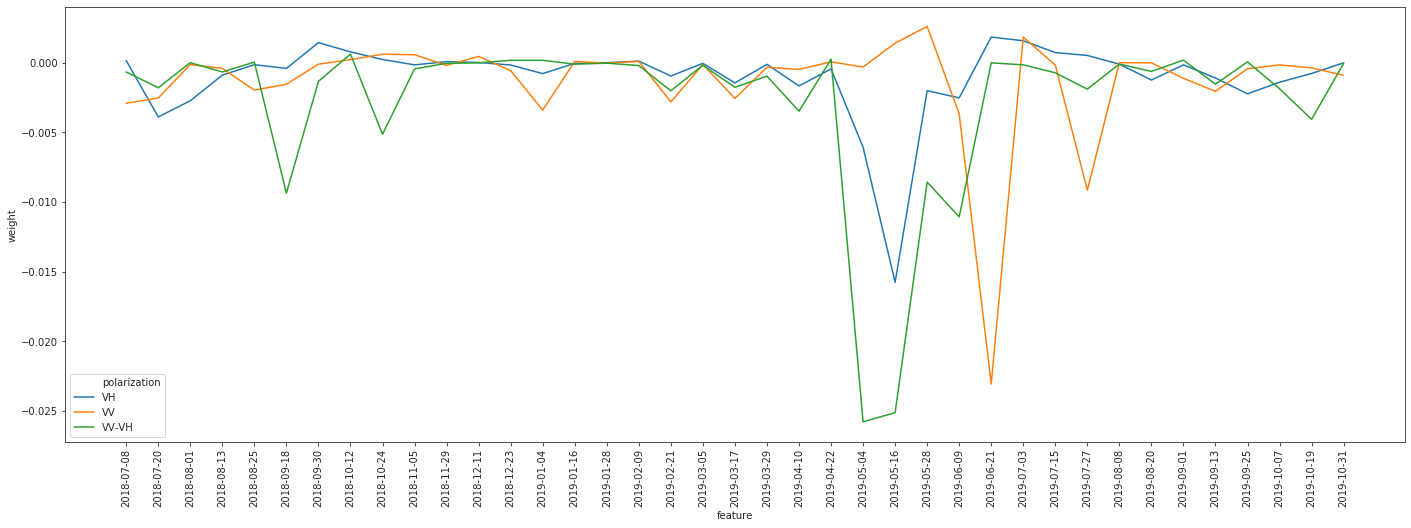

time: 597 ms


In [12]:
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='polarization', data=df_explanation, ci='sd')

In [13]:
#df_explanation = eli5.formatters.as_dataframe.explain_prediction_df(perm, feature_names=list(feature_names))

time: 24.3 ms


In [14]:
# Show the calculated stds in the df as confidence interval on the plot
# https://stackoverflow.com/questions/58399030/make-a-seaborn-lineplot-with-standard-deviation-confidence-interval-specified-f
#lower_bound = [M_new_vec[i] - Sigma_new_vec[i] for i in range(len(M_new_vec))]
#upper_bound = [M_new_vec[i] + Sigma_new_vec[i] for i in range(len(M_new_vec))]
#plt.fill_between(x_axis, lower_bound, upper_bound, alpha=.3)

time: 35.9 ms


In [15]:
df_explanation = eli5.formatters.as_dataframe.explain_weights_df(clf, feature_names=list(feature_names), target_names=class_names)
df_explanation = df_explanation.sort_values(by=['feature', 'target'])
df_explanation['polarization'] = ''
features = df_explanation['feature'].unique()
features = features[:-1]  # The last features are the bias values
df_bias_values = df_explanation[df_explanation['feature'] == '<BIAS>']

df_explanation = df_explanation[df_explanation['feature'] != '<BIAS>']
for feature in features:
    if feature[-5:] == 'VV-VH':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV-VH'
        df_explanation = df_explanation.replace(feature, feature[:-6])
    elif feature[-2:] == 'VV':
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VV'
        df_explanation = df_explanation.replace(feature, feature[:-3])
    else:
        df_explanation.loc[df_explanation['feature'] == feature, 'polarization'] = 'VH'
        df_explanation = df_explanation.replace(feature, feature[:-3])

time: 522 ms


In [16]:
df_bias_values

,target,feature,weight,polarization
118,Barley,<BIAS>,4.759261,
1062,Forest,<BIAS>,1.562478,
944,Grass,<BIAS>,1.211176,
590,Maize,<BIAS>,1.335081,
472,Oat,<BIAS>,2.399683,
4,Potato,<BIAS>,0.719987,
825,Rapeseed,<BIAS>,-3.635084,
360,Rye,<BIAS>,0.435380,
943,Sugarbeet,<BIAS>,-11.349453,
236,Wheat,<BIAS>,2.561493,


time: 32.1 ms


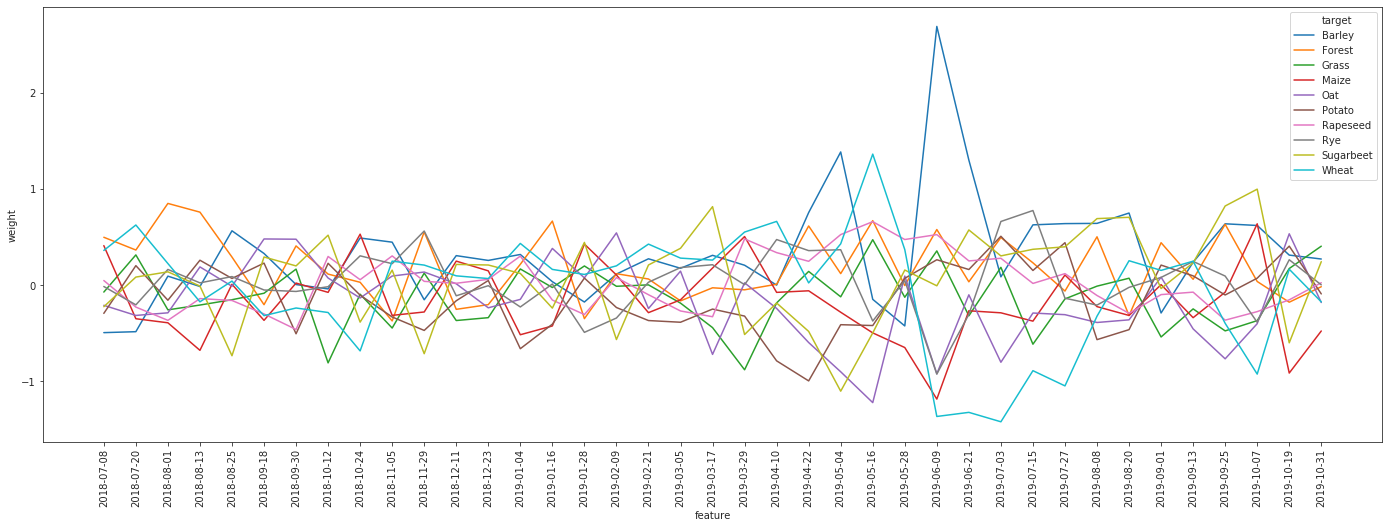

time: 616 ms


In [72]:
data = df_explanation[df_explanation['polarization'] == 'VH']
#data = data.loc[data['target'].isin(['Forest', 'Maize', 'Rapeseed'])]
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='target', data=data, ci='sd')

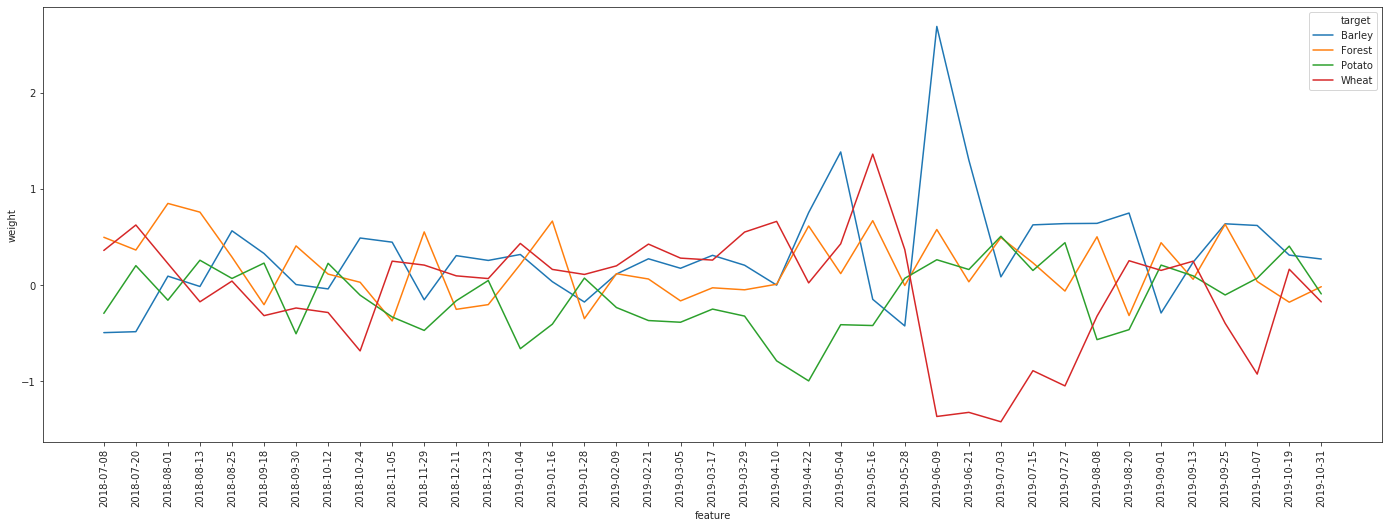

time: 510 ms


In [17]:
data = df_explanation[df_explanation['polarization'] == 'VH']
data = data.loc[data['target'].isin(['Barley', 'Wheat', 'Forest', 'Potato'])]
plt.figure(figsize=(24, 8))
plt.xticks(rotation=90, horizontalalignment='center')
ax = sns.lineplot(x='feature', y='weight', hue='target', data=data, ci='sd')